# DeepDream

We'll describe an implementation of DeepDream.

## Load Data

We'll load the example image of the Drosophila ssTEM dataset from https://figshare.com/articles/dataset/Segmented_anisotropic_ssTEM_dataset_of_neural_tissue/856713. Alternatively, you can download an image from the corresponding GiHub repository: http://github.com/unidesigner/groundtruth-drosophila-vnc.

In [8]:
from PIL import Image

im = Image.open("neuraltissue_with_colorlabels.png").convert('RGB').resize((256, 256))

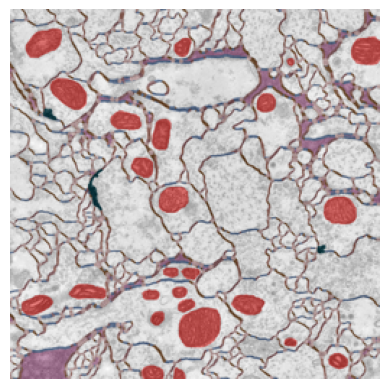

In [9]:
import matplotlib.pyplot as plt

plt.imshow(im)
plt.axis('off')
plt.show()

We download a pretrained model (VGG16), with the weigths o and freeze all the weights.

In [10]:
import torchvision.models as models
from torchvision.models import VGG16_Weights

model = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

model.eval()
model.requires_grad_(False)

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

The VGG16 is pretrained on the ImageNet dataset and the inputs are normalized wih respect to the mean and standard deviation of the channels of this dataset.

In [11]:
import numpy as np
mean_ds = np.array([0.485, 0.456, 0.406], dtype=np.float32)
std_ds = np.array([0.229, 0.224, 0.225], dtype=np.float32)

We'll define a function that perform loss maximization through gradient ascend. 

In [12]:
def deepdream(im, test_layer, num_iterations=100, step_size=0.01):

    import torch
    from deepdream import fwd_hooks, preprocess, deprocess
    import numpy as np
    from PIL import Image

    image = preprocess(im, mean_ds, std_ds)
    
    low = torch.tensor((-mean_ds / std_ds).reshape(1, -1, 1, 1))
    high = torch.tensor(((1 - mean_ds) / std_ds).reshape(1, -1, 1, 1))

    for t in range(num_iterations):
 
        with fwd_hooks(test_layers) as fh:
            out = model(image)

        losses = [] 
        for f in fh.stored:
            losses.append( f.mean() )
        loss = torch.stack(losses).sum()
        loss.backward()

        image.data += step_size*((image.grad.data - torch.mean(image.grad.data) )/(torch.std(image.grad.data)+1e-8))
        image.grad.data.zero_()

        image.data.clamp_(low, high)

    return Image.fromarray(np.uint8(np.clip(deprocess(image.data.clone(), mean_ds, std_ds)*255,0,255)), 'RGB')

We'll apply deepdreams to the image, using as output the activations of the first ReLU.

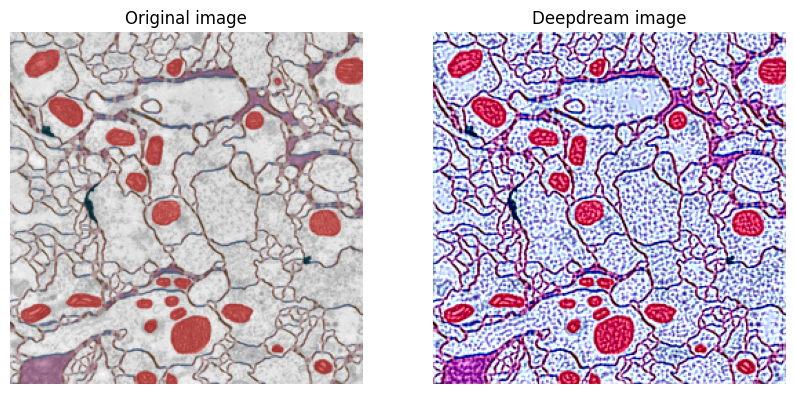

In [13]:
from deepdream import plot_dream

test_layers = [model.features[1]]
im_out  =  deepdream(im, test_layers, num_iterations=100, step_size=.01)

plot_dream(im, im_out)

By using deeper layer activations, we'll enhance features at larger scales. 

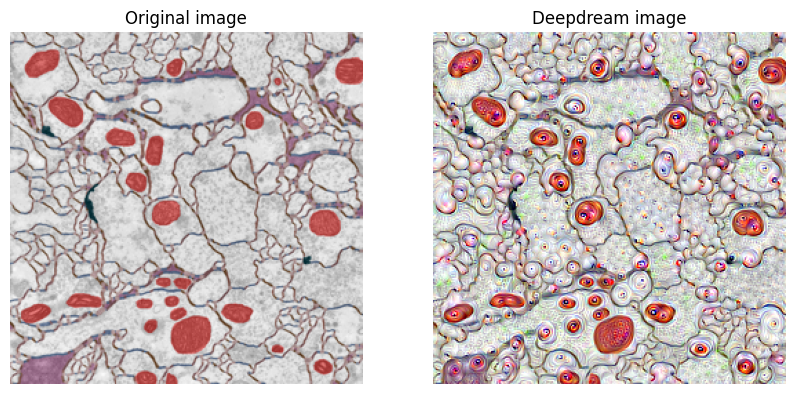

In [14]:
from deepdream import plot_dream
test_layers = [model.features[18]] 
im_out  =  deepdream(im, test_layers, num_iterations=100, step_size=.01)
plot_dream(im, im_out)

We'll combine images at different resolutions using octaves. (This can take a few minutes to complete).

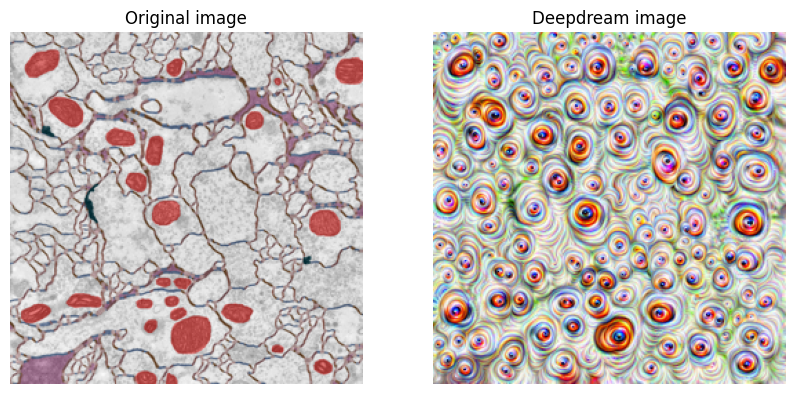

In [15]:
octave_scale = 1.4
im_oct = im
test_layers = [ model.features[18]]

for n in range(-2,3):
    im_oct = im_oct.resize((int(im.size[0]*(octave_scale**n)),int(im.size[1]*(octave_scale**n))))
    im_oct  =  deepdream(im_oct, test_layers, num_iterations=100, step_size=.01)
    im_oct = im_oct.resize(im.size)

plot_dream(im, im_oct)

We can furthermore use the output of several layers simultaneously to enhance multiple features. (This can take a few minutes to complete).

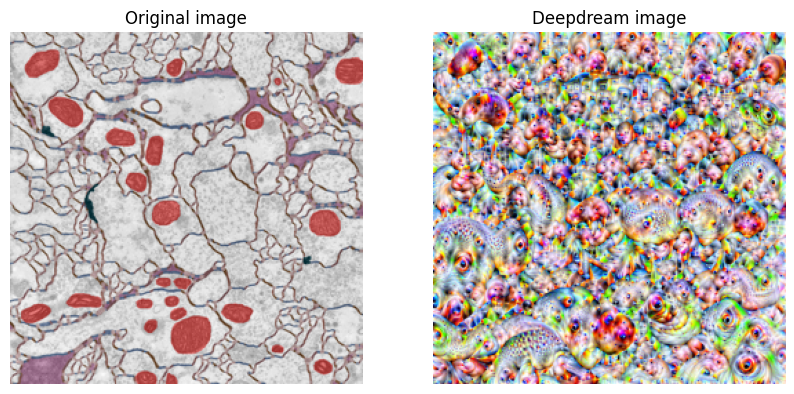

In [16]:
octave_scale = 1.4
im_oct = im

ind = [15, 18, 20, 22, 25, 27, 29]
test_layers = [ model.features[i] for i in ind ] 

for n in range(-2,3):
    im_oct = im_oct.resize((int(im.size[0]*(octave_scale**n)),int(im.size[1]*(octave_scale**n))))
    im_oct  =  deepdream(im_oct, test_layers, num_iterations=200, step_size=.01)
    im_oct = im_oct.resize(im.size)

plot_dream(im, im_oct)